In [12]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
import os
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import RF_regressor, plot_importances, encode_tulabel
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.utils.directories import get_parent_directory
from src.visualisation.visual_func import visual_predictions

In [3]:
parent_dir = get_parent_directory()

## IPY Barneo 2008

In [98]:
# Specify the path and filename for the pickle file
pickle_path_RF = os.path.join(parent_dir, "models/RandomForest/Barneo2008_testdf.pkl")
RF_testdf = pd.read_pickle(pickle_path_RF)

# Specify the path and filename for the pickle file
pickle_path_XGB = os.path.join(parent_dir, "models/XGBoost/Barneo2008_testdf.pkl")
# Pickle the DataFrame
XGB_testdf = pd.read_pickle(pickle_path_XGB)

# Specify the path and filename for the pickle file
pickle_path_global = os.path.join(parent_dir, "models/XG_global/Barneo2008_testdf.pkl")
# Pickle the DataFrame
global_testdf = pd.read_pickle(pickle_path_global)

In [87]:
# Specify the path and filename for the pickle file
pickle_path_XGB_7 = os.path.join(parent_dir, "models/XGBoost/Barneo2008_7_testdf.pkl")
# Pickle the DataFrame
XGB_testdf_7 = pd.read_pickle(pickle_path_XGB_7)


## Performance metrics

In [99]:
from src.models.corr_func import score_metrics

In [102]:
log_eps_df = pd.DataFrame(XGB_testdf_7["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf_7["eps_pred"])
score_metrics(log_eps_df, XGB_testdf_7["eps_pred"])

R2 Score: 0.2261
Mean Error (ME): 0.0695
Mean Absolute Error (MAE): 0.2152
Residual Standard Deviation: 0.3213


In [103]:
log_eps_df = pd.DataFrame(XGB_testdf["log_eps"])
pred_eps_df = pd.DataFrame(XGB_testdf["eps_pred"])
score_metrics(log_eps_df, XGB_testdf["eps_pred"])

R2 Score: -0.6084
Mean Error (ME): 0.2514
Mean Absolute Error (MAE): 0.3570
Residual Standard Deviation: 0.4017


In [133]:

def plot_predictions(cruise, parent_dir):
    """
    Plots the mean predicted epsilon values along with the ground truth
    epsilon values for different models (Random Forest, XGBoost, and XGBoost
    7 features) as a function of depth.

    Parameters:
        cruise (str): The name of the cruise.
        parent_dir (str): The parent directory where the pickle files are located.

    Returns:
        None

    Example:
        plot_predictions("cruise1", "/path/to/parent_dir")
    """
    # Specify the path and filename for the pickle file
    cruise_file = cruise + "_testdf.pkl"
    pickle_path_RF = os.path.join(parent_dir, "models/RandomForest", cruise_file)
    RF_testdf = pd.read_pickle(pickle_path_RF)

    # Specify the path and filename for the pickle file
    pickle_path_XGB = os.path.join(parent_dir, "models/XGBoost", cruise_file)
    XGB_testdf = pd.read_pickle(pickle_path_XGB)

    # Specify the path and filename for the pickle file
    pickle_path_XGB_7 = os.path.join(parent_dir, "models/XGBoost_7", cruise_file)
    XGB_7_testdf = pd.read_pickle(pickle_path_XGB_7)

    sorted_df_XGB = XGB_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB = sorted_df_XGB[sorted_df_XGB['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_XGB = sampled_df_XGB.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost
    std_dev_XGB = mean_df_XGB['eps_pred'].std()
    ci_lower_XGB = mean_df_XGB['eps_pred'] - std_dev_XGB  # Lower bound of the confidence interval
    ci_upper_XGB = mean_df_XGB['eps_pred'] + std_dev_XGB  # Upper bound of the confidence interval

    sorted_df_RF = RF_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_RF = sorted_df_RF[sorted_df_RF['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of epsilon predictions
    mean_df_RF = sampled_df_RF.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation
    std_dev_RF = mean_df_RF['eps_pred'].std()
    ci_lower_RF = mean_df_RF['eps_pred'] - std_dev_RF  # Lower bound of the confidence interval
    ci_upper_RF = mean_df_RF['eps_pred'] + std_dev_RF  # Upper bound of the confidence interval

    sorted_df_XGB_7 = XGB_7_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_XGB_7 = sorted_df_XGB_7[sorted_df_XGB_7['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost 7 features epsilon predictions
    mean_df_XGB_7 = sampled_df_XGB_7.groupby('depth')['eps_pred'].mean().reset_index()
    # Calculate the standard deviation for XGBoost 7 features
    std_dev_XGB_7 = mean_df_XGB_7['eps_pred'].std()
    ci_lower_XGB_7 = mean_df_XGB_7['eps_pred'] - std_dev_XGB_7  # Lower bound of the confidence interval
    ci_upper_XGB_7 = mean_df_XGB_7['eps_pred'] + std_dev_XGB_7  # Upper bound of the confidence interval

    sorted_df_GT = XGB_testdf.sort_values('depth')
    # Sample every 10 meters
    sampled_df_GT = sorted_df_GT[sorted_df_GT['depth'] % 8 == 0]
    # Group the data by depth and calculate the mean of XGBoost epsilon predictions
    mean_df_GT = sampled_df_GT.groupby('depth')['log_eps'].mean().reset_index()

   #plt.plot(mean_df_RF['eps_pred'], mean_df_RF['depth'], label='RandomForest Mean Epsilon')
    #plt.fill_betweenx(mean_df_RF['depth'], ci_lower_RF, ci_upper_RF, alpha=0.1, label='Random Forest Std')

    plt.plot(mean_df_XGB_7['eps_pred'], mean_df_XGB_7['depth'], label='XGBoost 7 features Mean Epsilon')
    plt.fill_betweenx(mean_df_XGB_7['depth'], ci_lower_XGB_7, ci_upper_XGB_7, alpha=0.1, label='XGBoost 7 Std')

    plt.plot(mean_df_XGB['eps_pred'], mean_df_XGB['depth'], label='XGBoost Mean Epsilon')
    plt.fill_betweenx(mean_df_XGB['depth'], ci_lower_XGB, ci_upper_XGB, alpha=0.1, label='XGBoost Std')
    
    plt.plot(mean_df_GT['log_eps'], mean_df_GT['depth'], label='Ground Truth Epsilon')

    plt.xlabel('$log_{10}(\epsilon)$')
    plt.ylabel('Depth (m)')
    plt.title(cruise + ' mean Predicted $log_{10} \epsilon$')
    plt.grid(True)
    plt.legend()

    plt.gca().invert_yaxis()  # Invert the y-axis

    plt.show()


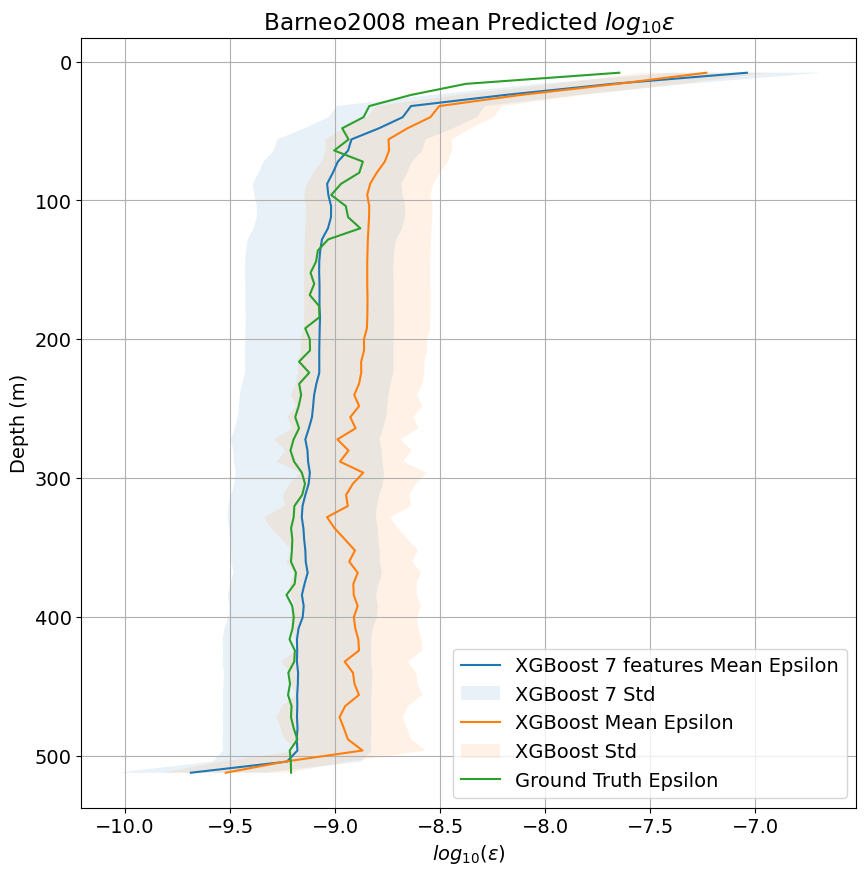

In [134]:
plot_predictions("Barneo2008", parent_dir)

# ArcticMix plots

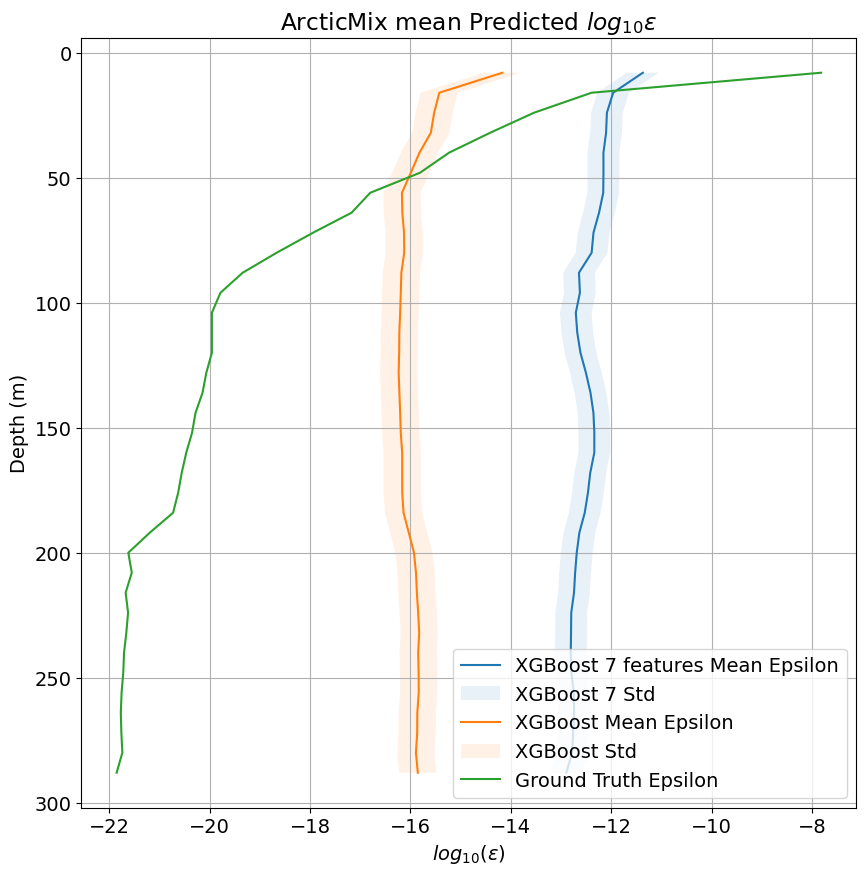

In [137]:
plot_predictions("ArcticMix", parent_dir)

## TEA-COSI plots

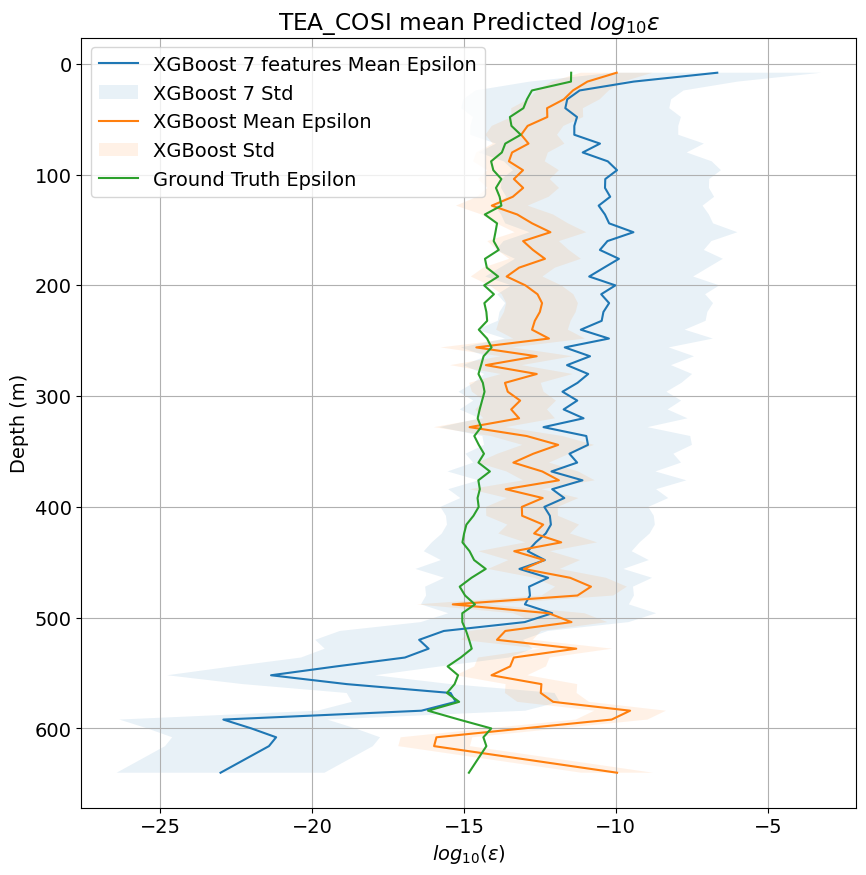

In [138]:
# global -6.4
# XGBoost -5.4
# RandomForest -9.95
plot_predictions("TEA_COSI", parent_dir)

In [140]:
# Specify the path and filename for the pickle file
pickle_path_RF = os.path.join(parent_dir, "models/RandomForest/TEA_COSI_testdf.pkl")
RF_testdf = pd.read_pickle(pickle_path_RF)

# Specify the path and filename for the pickle file
pickle_path_XGB = os.path.join(parent_dir, "models/XGBoost/TEA_COSI_testdf.pkl")
# Pickle the DataFrame
XGB_testdf = pd.read_pickle(pickle_path_XGB)

# Specify the path and filename for the pickle file
pickle_path_X7 = os.path.join(parent_dir, "models/XGBoost_7/TEA_COSI_testdf.pkl")
# Pickle the DataFrame
X7_testdf = pd.read_pickle(pickle_path_X7)